In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import awkward as ak
from fast_histogram import histogram2d
import seaborn as sn
from sklearn.preprocessing import normalize
import h5py
import os
import sys
from pathlib import Path

# Converting calorimeter input to 2D histogram images

This script creates calorimeter images based on the calorimeter data from the ATLAS Open jet reconstruction data. 

In [2]:
MIN_RES = 20
RESOLUTION = int(5*MIN_RES)
N_events = 1000 #events to load
MAX_EVENTS = 1000 #images to make
savepath = "/disk/atlas3/data_MC/2dhistograms"
filename = "ttbar"

#data_paths = ['/disk/atlas3/data_MC/delphes/black_holes_10000events.root:Delphes']
data_paths = ["/disk/atlas3/data_MC/delphes/BH_n4_M10_1000events.root:Delphes"]
#data_paths = ["/disk/atlas3/data_MC/delphes/sphalerons.root:Delphes"]

filters = ["saturate"]
#filters = ["none"]

In [3]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from machine_learning import CalorimeterDataset
from resnet import *
from imcal import *

Using the with uproot loop, we can extract only the data we need and then close the original file. This will save us memory space.

In [4]:

#Load data
clusters = [load_data(path, MAX_EVENTS, "Tower", 
                        ["Tower.ET", "Tower.Eta", "Tower.Phi", "Tower.Eem", "Tower.Ehad", "Tower.E"])
                        for path in data_paths]
tracks = [load_data(path, MAX_EVENTS, "Track", 
                        ["Track.PT", "Track.Eta", "Track.Phi"])
                        for path in data_paths]


In [5]:
#Pad Tower data and normalise
max_hits = np.max([np.max([len(event) for event in item["Eta"]]) for item in clusters])
print(max_hits)
clusters = [ak.pad_none(item, max_hits, axis=-1) for item in clusters]

#Pad track data and normalise
max_hits = np.max([np.max([len(event) for event in item["Eta"]]) for item in tracks])
print(max_hits)
tracks = [ak.pad_none(item, max_hits, axis=-1) for item in tracks]


601
509


We create the histograms by using the [fast-histogram library](https://pypi.org/project/fast-histogram/), which is 20-25 x faster than numpy.histogram2d. It does not support advanced binning however, so we perform a simple binning equal to the desired resolution of the image. 

In [6]:
hists_Eem = create_histograms(ak.to_numpy(clusters[0].Phi), ak.to_numpy(clusters[0].Eta), 
                                ak.to_numpy(clusters[0].Eem), MAX_EVENTS, RESOLUTION)
hists_Ehad = create_histograms(ak.to_numpy(clusters[0].Phi), ak.to_numpy(clusters[0].Eta), 
                                ak.to_numpy(clusters[0].Ehad), MAX_EVENTS, RESOLUTION)
hists_tracks = create_histograms(ak.to_numpy(tracks[0].Phi), ak.to_numpy(tracks[0].Eta), 
                                    ak.to_numpy(tracks[0].PT), MAX_EVENTS, RESOLUTION)

hists = np.stack((hists_Eem, hists_Ehad, hists_tracks), axis=-1)
print(hists.shape)

(1000, 100, 100, 3)


[]

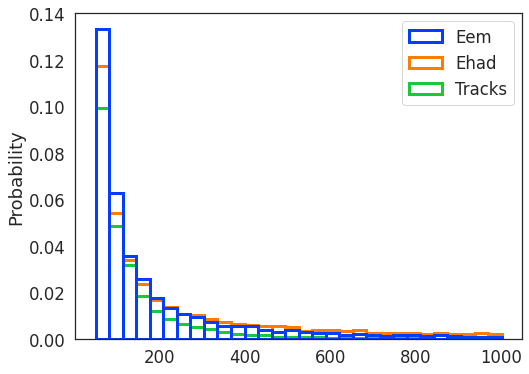

In [41]:
fig, ax = plt.subplots(ncols=1, figsize=(8, 6))
labels = ["Eem", "Ehad", "Tracks"]
data = [ak.to_numpy(clusters[0].Eem).flatten(), ak.to_numpy(clusters[0].Ehad).flatten(), ak.to_numpy(tracks[0].PT).flatten()]
sn.set_theme(context="notebook", style="white", palette="bright", font='sans-serif', font_scale=1.5, color_codes=True, rc=None)

sn.histplot(dict(zip(labels, data)), ax = ax, bins=30, binrange=(50, 1000), 
            multiple="layer", stat="probability", linewidth=3, fill=False)
plt.plot()

Remember that python histograms produce images with input 2 (eta) on the x-axis and input 1 (phi) on the y-axis.

763
[ 289.65212917  342.62142944  371.80373669  383.49658203  421.57366943
  620.46854782  752.82037354 1089.73547363 1232.72497559]
Applying saturate filter.
[0.57930426 0.68524286 0.74360747 0.76699316 0.84314734 1.
 1.         1.         1.        ]


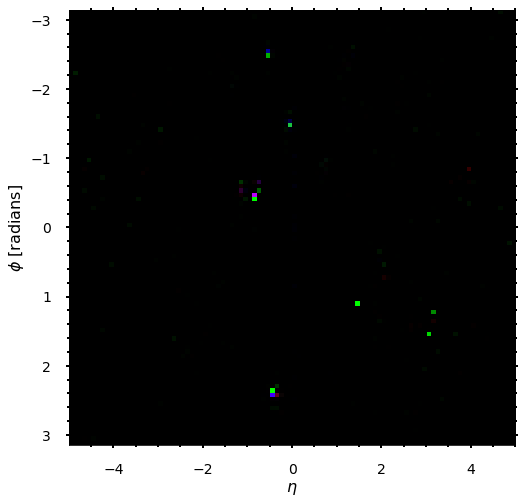

In [7]:
k = np.random.randint(0, high=len(hists_Eem)) #a random image
print(k)
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
cal_image_plot(axs)
image = hists[k]
print(np.sort(image.flatten())[-10:-1])
image = apply_filters(filters, image, maxvalue=500)
print(np.sort(image.flatten())[-10:-1])
axs.imshow(image, extent=[-5, 5, np.pi, -np.pi], aspect='auto')

Applying saturate filter.
Event nr:  [[401 996 391 699]
 [733 769 247 290]
 [890 587 959 117]
 [171 535 993 620]]


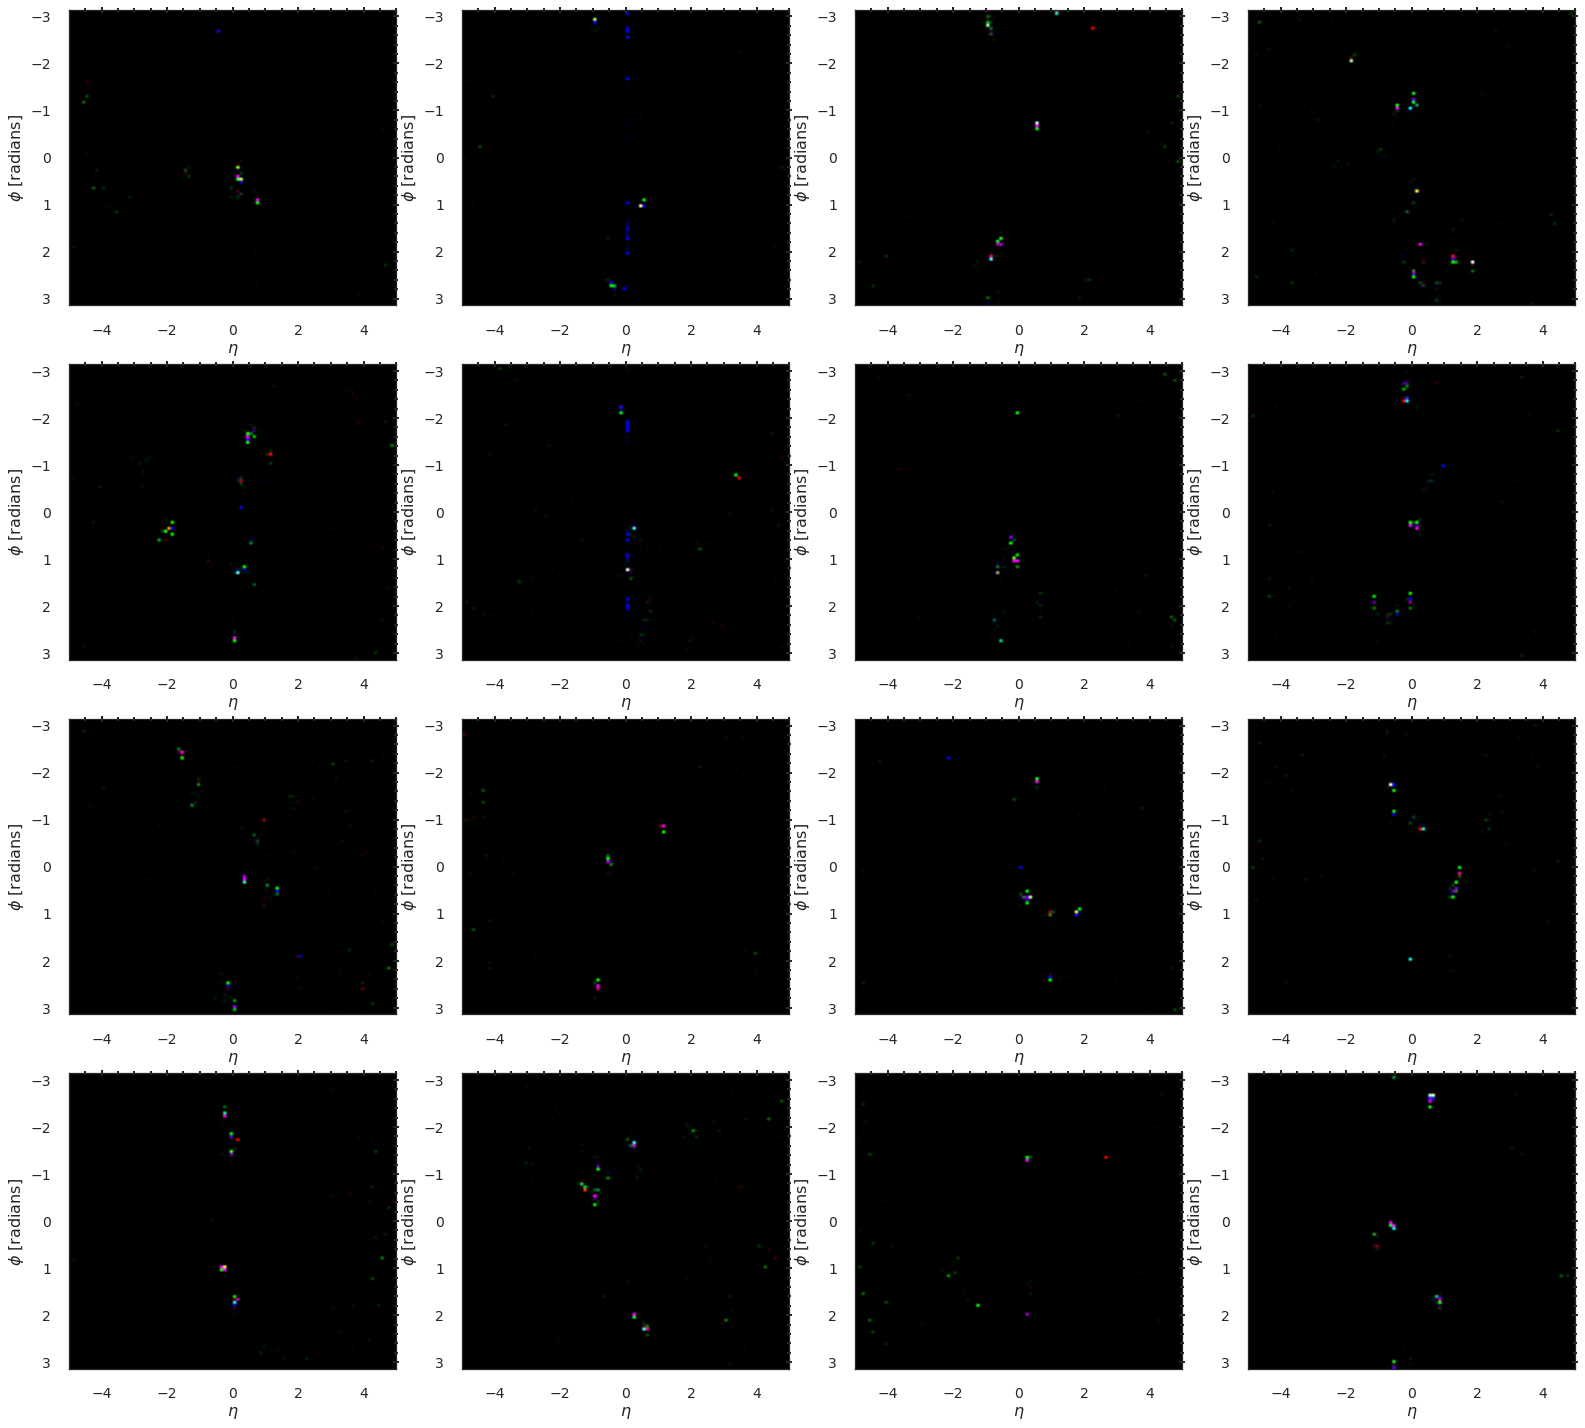

In [43]:
fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize = (27,25))
image_ids = np.random.randint(0, high=len(hists), size=(4,4))
images = hists[image_ids]
images = apply_filters(filters, images, maxvalue=200)

print("Event nr: ", image_ids)
for i in range(4):
    for j in range(4):
        cal_image_plot(axs[i][j])
        axs[i][j].imshow(images[i][j], extent=[-5, 5, np.pi, -np.pi], aspect='auto')


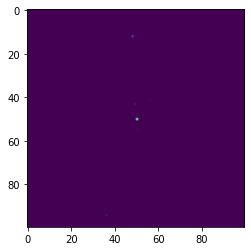

In [9]:
plt.imshow(hists_tracks[855])

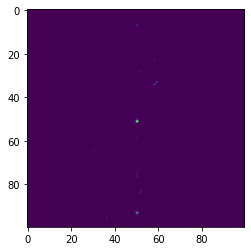

In [10]:
plt.imshow(hists_tracks[827])

In [11]:
def store_many_hdf5(images, savepath, filename, filters, labels=None):
    """ Stores an array of images to HDF5.
        Parameters:
        ---------------
        images       images array, (MAX_EVENTS, RESOLUTION, RESOLUTION, 3) to be stored
        labels       labels array, (MAX_EVENTS, 1) to be stored
    """
    num_images = len(images)
    
    def make_filter_code(filters):
        if filters[0] != "":
            letter_list = [x[0]+"_" for x in filters]
            code = ""
            code = code.join(letter_list)
            code = code[:-1]
        return str(code)
    filter_code = make_filter_code(filters)
    print(f"{savepath}/{filename}_{MAX_EVENTS}_events_{filter_code}.h5")

    # Create meta data
    meta = {
        "RESOLUTION": RESOLUTION,
        "Filters" : filters,
        "Events" : MAX_EVENTS,
        "Input" : data_paths[0]
    }

    # Create a new HDF5 file
    file = h5py.File(f"{savepath}/{filename}_{MAX_EVENTS}_events_{filter_code}.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "images", np.shape(images), h5py.h5t.STD_U8BE, data=images
    )
    for key, value in meta.items():
        meta_set = file.create_dataset(
            key, np.shape(value), data=value
        )
    file.close()

#store_many_hdf5(images, savepath, filename, filters)